In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt

from s7_datasets import load_data_S7
from utils import train_S7,test_S7,plot_acc_loss_S7
from models import model_summary,S7_Model_4


c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
use_cuda = torch.cuda.is_available()  # Check if CUDA (GPU support) is available
device = torch.device("cuda" if use_cuda else "cpu")  # Select GPU if available, otherwise fall back to CPU
device  # Display the selected device

device(type='cpu')

In [3]:
trainloader , testloader = load_data_S7()

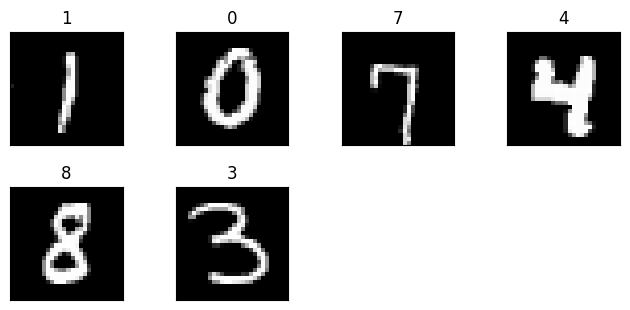

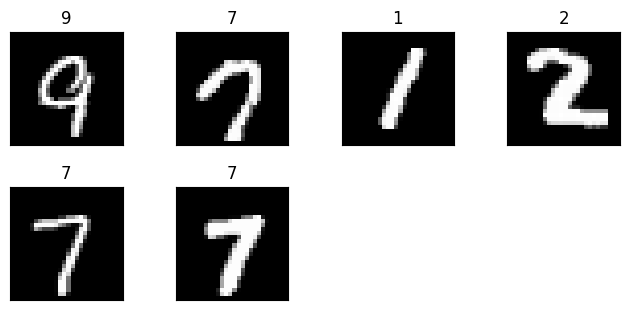

In [8]:
def plot_image(loader,no_images):
    batch_data, batch_label = next(iter(loader))
    _ = plt.figure()

    for i in range(no_images):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        plt.imshow(batch_data[i].squeeze(0), cmap='gray')
        plt.title(batch_label[i].item())
        plt.xticks([])
        plt.yticks([])


plot_image(trainloader,6)
plot_image(testloader,6)

In [5]:
model = S7_Model_4()
model_summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             576
       BatchNorm2d-2           [-1, 64, 26, 26]             128
              ReLU-3           [-1, 64, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]           4,616
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
         MaxPool2d-7            [-1, 8, 12, 12]               0
            Conv2d-8            [-1, 4, 12, 12]              36
       BatchNorm2d-9            [-1, 4, 12, 12]               8
             ReLU-10            [-1, 4, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             296
             ReLU-12            [-1, 8, 10, 10]               0
AdaptiveAvgPool2d-13              [-1, 8, 1, 1]               0
           Linear-14                   

In [6]:
model = S7_Model_4().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 15




for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_S7(model, device, trainloader, optimizer,criterion)
  scheduler.step()
  test_S7(model, device, testloader, criterion)
  


c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=0.4854 Batch_id=937 Accuracy=56.80: 100%|██████████| 938/938 [01:48<00:00,  8.61it/s]


Test set: Average loss: 0.0090, Accuracy: 8368/10000 (83.68%)

Epoch 2


Train: Loss=0.4107 Batch_id=937 Accuracy=87.14: 100%|██████████| 938/938 [02:13<00:00,  7.04it/s]


Test set: Average loss: 0.0059, Accuracy: 8850/10000 (88.50%)

Epoch 3


Train: Loss=0.3281 Batch_id=937 Accuracy=91.08: 100%|██████████| 938/938 [02:09<00:00,  7.25it/s]


Test set: Average loss: 0.0052, Accuracy: 9013/10000 (90.13%)

Epoch 4


Train: Loss=0.2611 Batch_id=937 Accuracy=92.74: 100%|██████████| 938/938 [02:05<00:00,  7.48it/s]


Test set: Average loss: 0.0032, Accuracy: 9436/10000 (94.36%)

Epoch 5


Train: Loss=0.1456 Batch_id=937 Accuracy=93.43: 100%|██████████| 938/938 [02:07<00:00,  7.35it/s]


Test set: Average loss: 0.0030, Accuracy: 9432/10000 (94.32%)

Epoch 6


Train: Loss=0.1012 Batch_id=937 Accuracy=95.32: 100%|██████████| 938/938 [02:10<00:00,  7.17it/s]


Test set: Average loss: 0.0024, Accuracy: 9546/10000 (95.46%)

Epoch 7


Train: Loss=0.1724 Batch_id=937 Accuracy=95.44: 100%|██████████| 938/938 [02:08<00:00,  7.28it/s]


Test set: Average loss: 0.0024, Accuracy: 9560/10000 (95.60%)

Epoch 8


Train: Loss=0.0936 Batch_id=937 Accuracy=95.55: 100%|██████████| 938/938 [02:07<00:00,  7.34it/s]


Test set: Average loss: 0.0024, Accuracy: 9574/10000 (95.74%)

Epoch 9


Train: Loss=0.0108 Batch_id=937 Accuracy=95.62: 100%|██████████| 938/938 [02:08<00:00,  7.33it/s]


Test set: Average loss: 0.0024, Accuracy: 9571/10000 (95.71%)

Epoch 10


Train: Loss=0.0319 Batch_id=937 Accuracy=95.64: 100%|██████████| 938/938 [02:03<00:00,  7.58it/s]


Test set: Average loss: 0.0024, Accuracy: 9570/10000 (95.70%)

Epoch 11


Train: Loss=0.0397 Batch_id=937 Accuracy=95.86: 100%|██████████| 938/938 [02:03<00:00,  7.60it/s]


Test set: Average loss: 0.0023, Accuracy: 9579/10000 (95.79%)

Epoch 12


Train: Loss=0.2033 Batch_id=937 Accuracy=95.88: 100%|██████████| 938/938 [02:03<00:00,  7.61it/s]


Test set: Average loss: 0.0023, Accuracy: 9584/10000 (95.84%)

Epoch 13


Train: Loss=0.1234 Batch_id=937 Accuracy=95.86: 100%|██████████| 938/938 [02:16<00:00,  6.86it/s]


Test set: Average loss: 0.0023, Accuracy: 9586/10000 (95.86%)

Epoch 14


Train: Loss=0.1771 Batch_id=937 Accuracy=95.89: 100%|██████████| 938/938 [02:12<00:00,  7.07it/s]


Test set: Average loss: 0.0023, Accuracy: 9580/10000 (95.80%)

Epoch 15


Train: Loss=0.1765 Batch_id=937 Accuracy=95.87: 100%|██████████| 938/938 [02:06<00:00,  7.43it/s]


Test set: Average loss: 0.0023, Accuracy: 9586/10000 (95.86%)



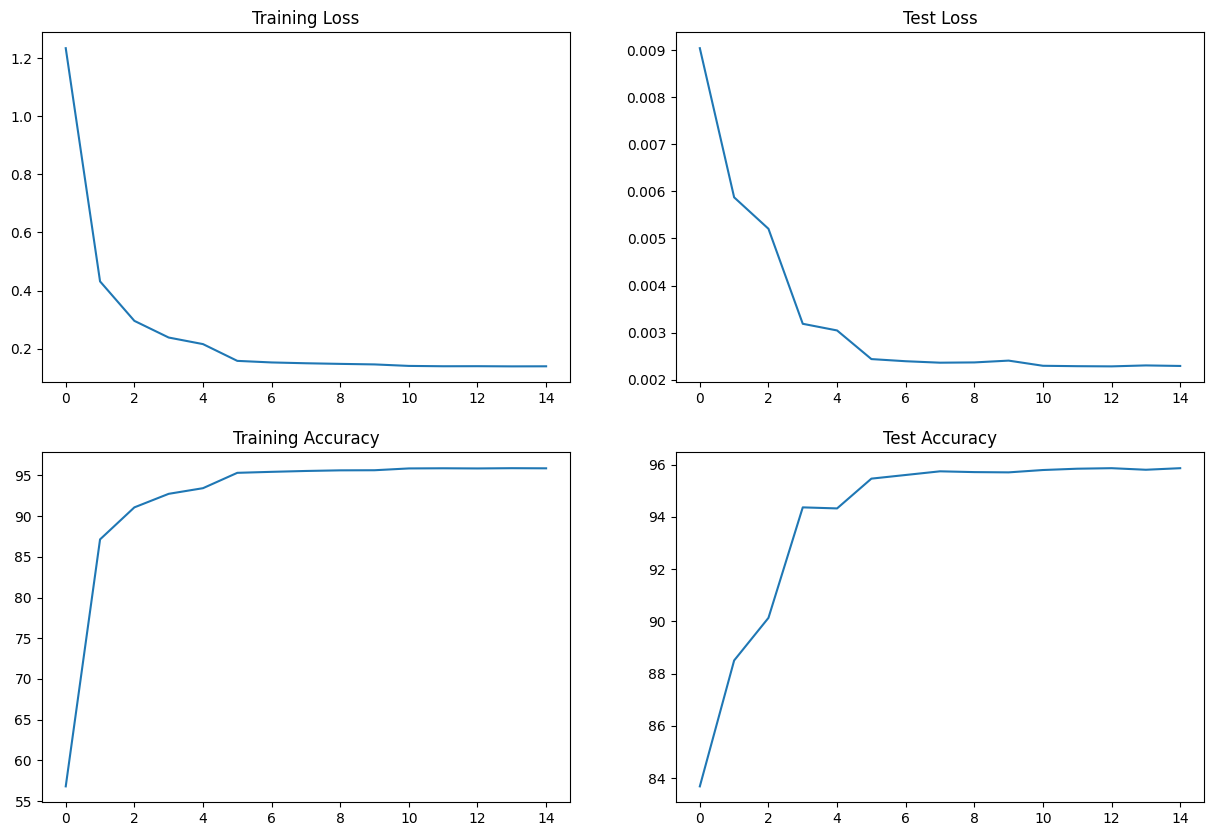

In [7]:
plot_acc_loss_S7()